In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import utils
from load_dataset import load_dataset, feature_extraction

pd.set_eng_float_format(accuracy=2, use_eng_prefix=True)

data_directory = "/Users/nepal/Documents/synapthesis/synData6July"
lotti_fn = "export_lotti_veneto_2016_2018_giulio_v2.csv"
vincitori_fn = "export_vincitori_veneto_2016_2018_giulio_v2.csv"
procedura_fn = "tipi_procedure.csv"

df = load_dataset(data_directory, lotti_fn, vincitori_fn, procedura_fn)
df = feature_extraction(df)
df.dtypes

importo values to substitute with importo_base_asta values percentage:           0.0012%
data_inizio values to substitute with data_inferita values percentage:           0.3145%
columns dropped with mostly missing values:
['oggetto', 'importo_liquidato', 'importo_base_asta', 'data_inferita', 'id_mod_realizz', 'cpv_vero']
dropped all the rows with at least one missing value


id_pa                                int64
id_scelta_contraente                 int64
importo                            float64
data_inizio                 datetime64[ns]
data_fine                   datetime64[ns]
id_lsf                               int64
id_forma_giuridica_pa                int64
uber_forma_giuridica_pa             object
cpv                                  int64
id_be                                int64
id_forma_giuridica_be                int64
uber_forma_giuridica_be             object
procedura                           object
tipo_procedura                      object
median_expenditure_pa              float64
median_revenue_be                  float64
contr_med_pa                       float64
contr_med_be                       float64
durata                     timedelta64[ns]
day_of_year_sin                    float64
day_of_year_cos                    float64
med_yearly_n_contr_pa              float64
med_yearly_n_contr_be              float64
dtype: obje

# anni e luogo dei contratti

# abc analysis for award procedures and cpv codes

category within 0.9 - ROW COUNT
id_scelta_contraente
1       6022
26     25998
4      32604
23    588116
dtype: int64


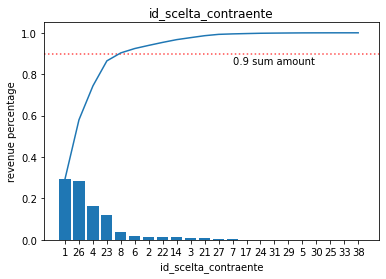

In [2]:
fig, ax = plt.subplots()
abc_scelta_contraente = utils.plot_abc_items(df, "id_scelta_contraente", ax, .9)

category within 0.64 - ROW COUNT
cpv
33    88586
45    32560
85     8514
79    17620
55    14015
dtype: int64


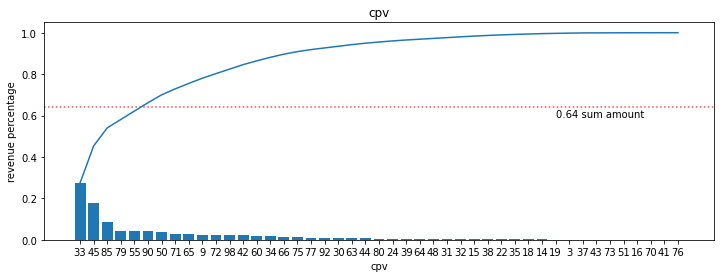

In [3]:
fig, ax = plt.subplots(figsize=(6*2, 4))
abc_cpv = utils.plot_abc_items(df, "cpv", ax, .64)

In [4]:
abc_procedures = [1, 26, 4, 23]
abc_cpv = [33, 45, 85, 79]

procedure_mask = df.id_scelta_contraente == abc_procedures[0]
for item in abc_procedures:
    procedure_mask += df.id_scelta_contraente == item
df = df[procedure_mask]

cpv_mask = df.cpv == abc_cpv[0]
for item in abc_cpv:
    cpv_mask += df.cpv == item
df = df[cpv_mask]

# scatterplots

is the contract duration linearly dependent on the contract amount?

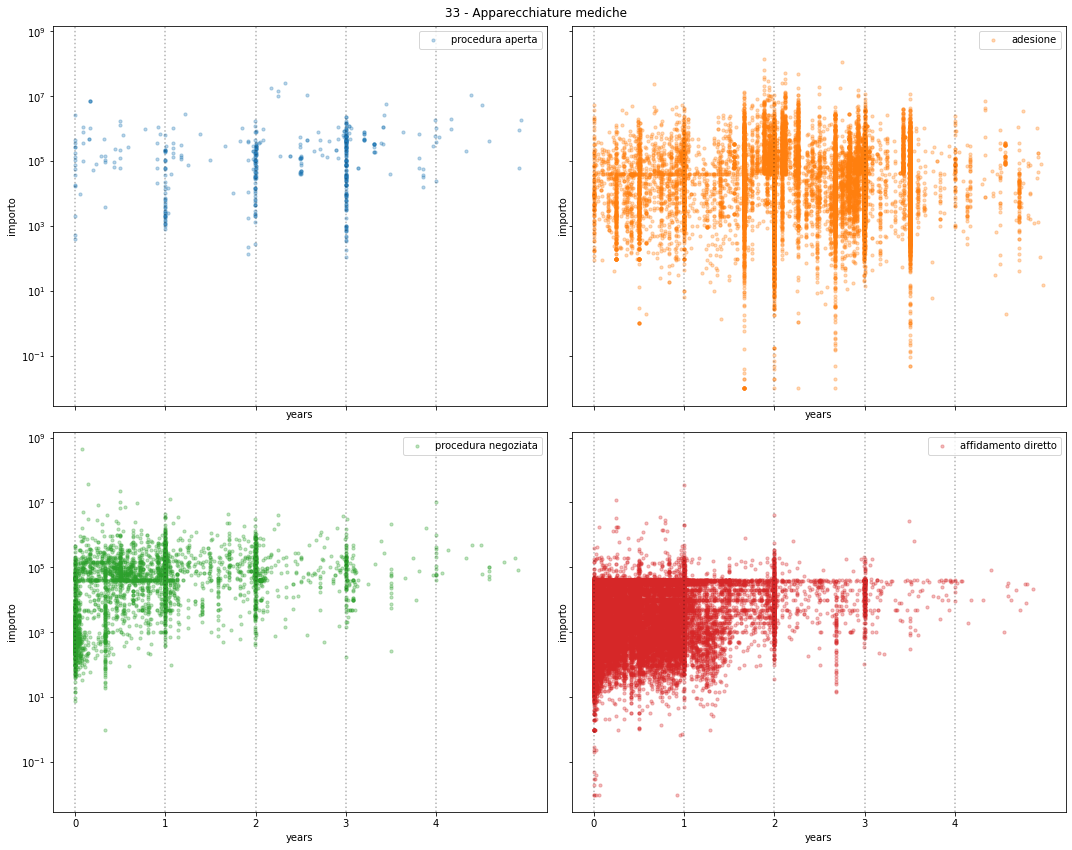

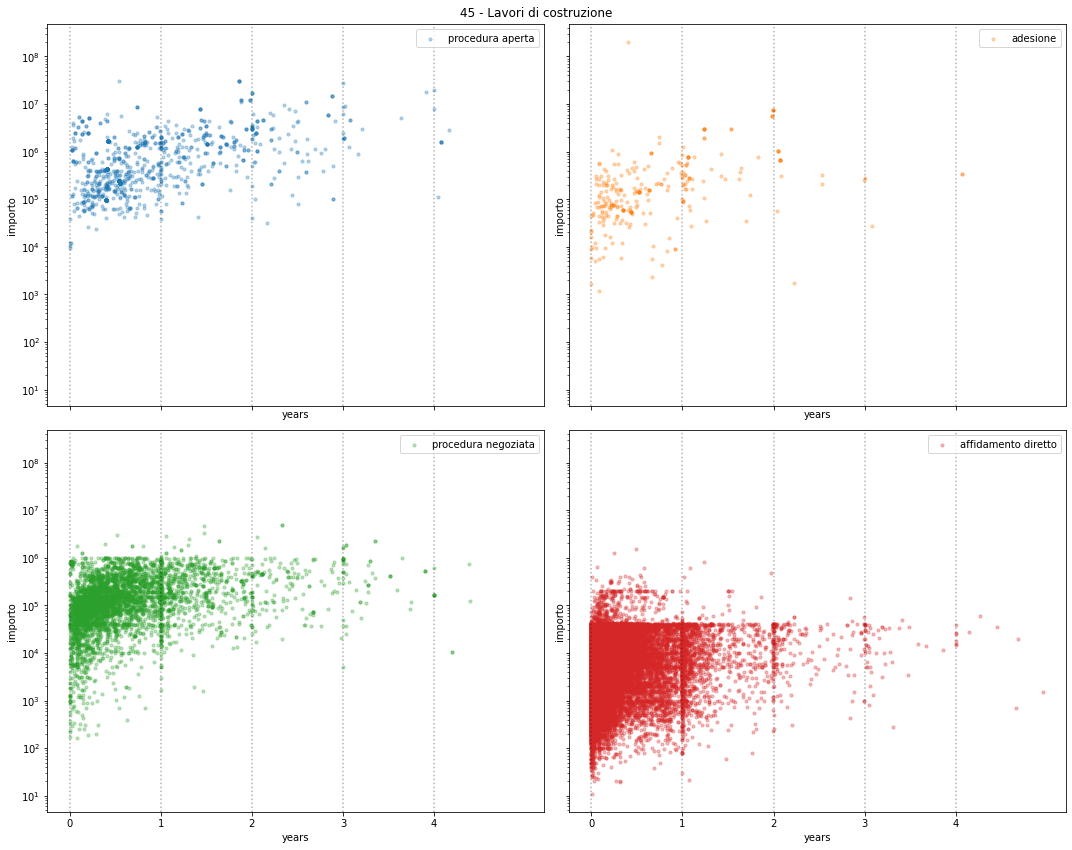

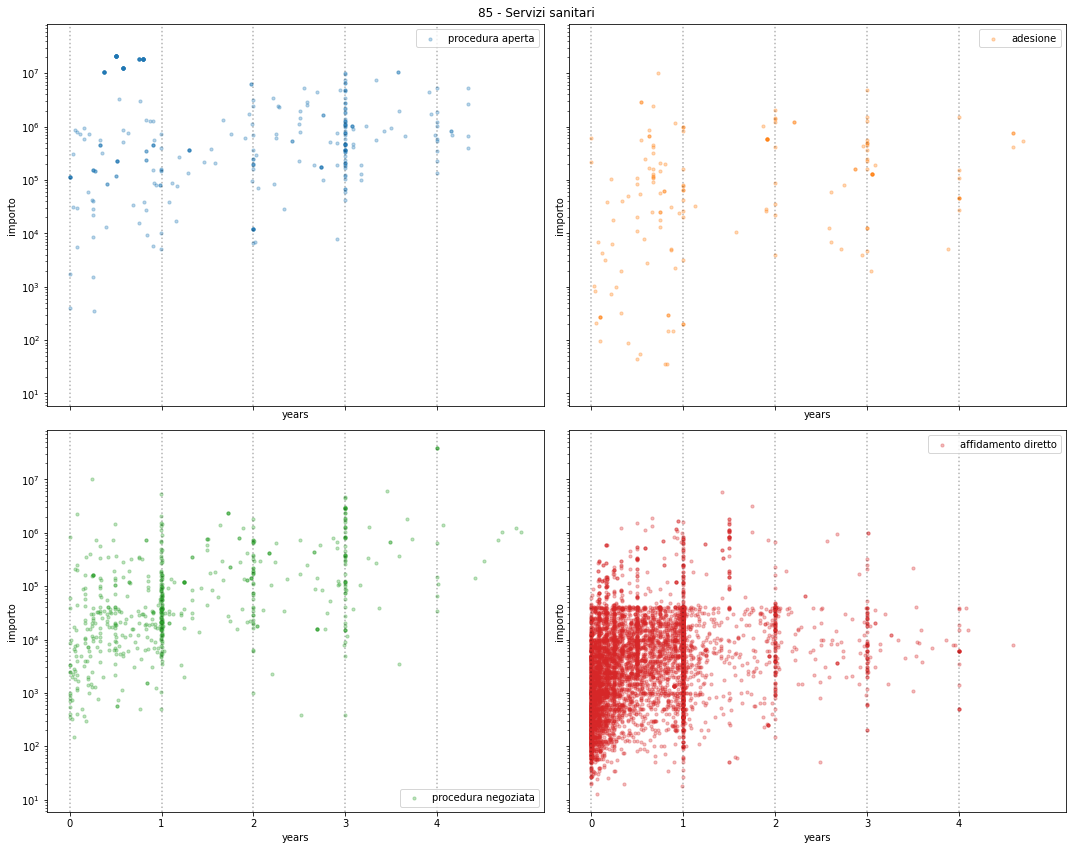

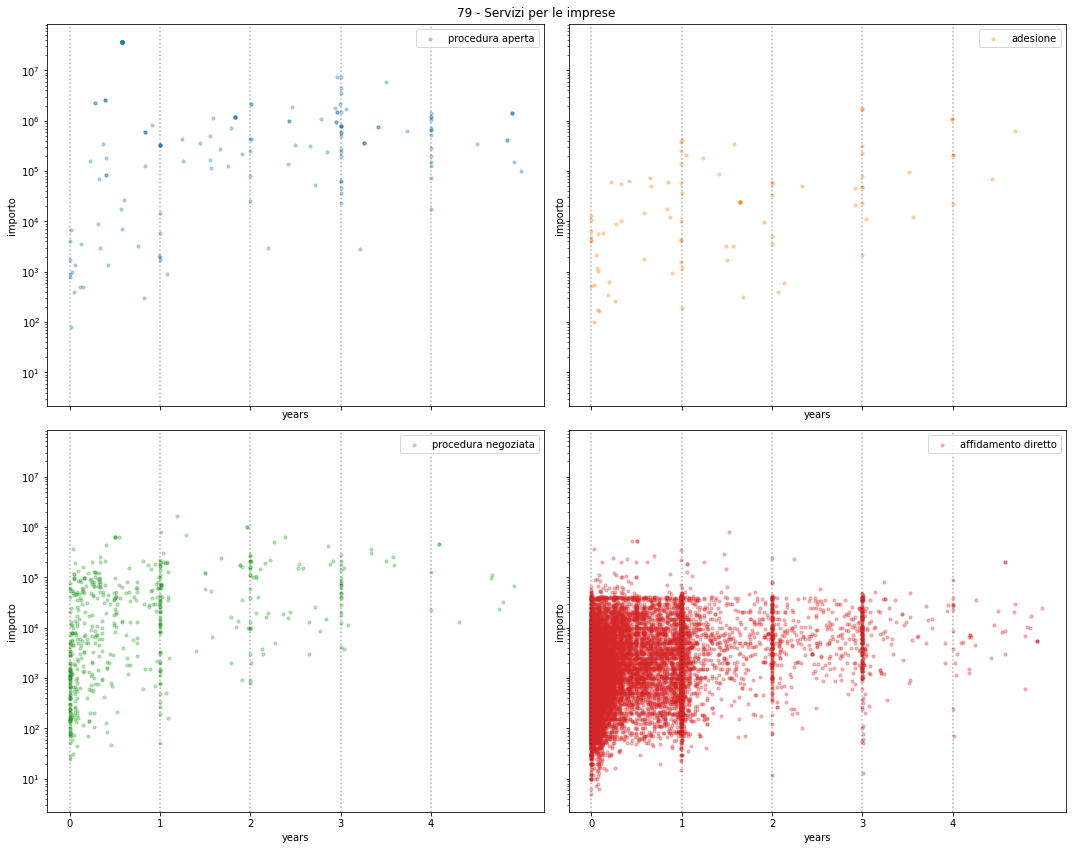

In [5]:
for cpv in abc_cpv:
    utils.scatter_quaternion("durata", "importo", df, cpv)

the bigger the contract amount, the bigger the business entity?

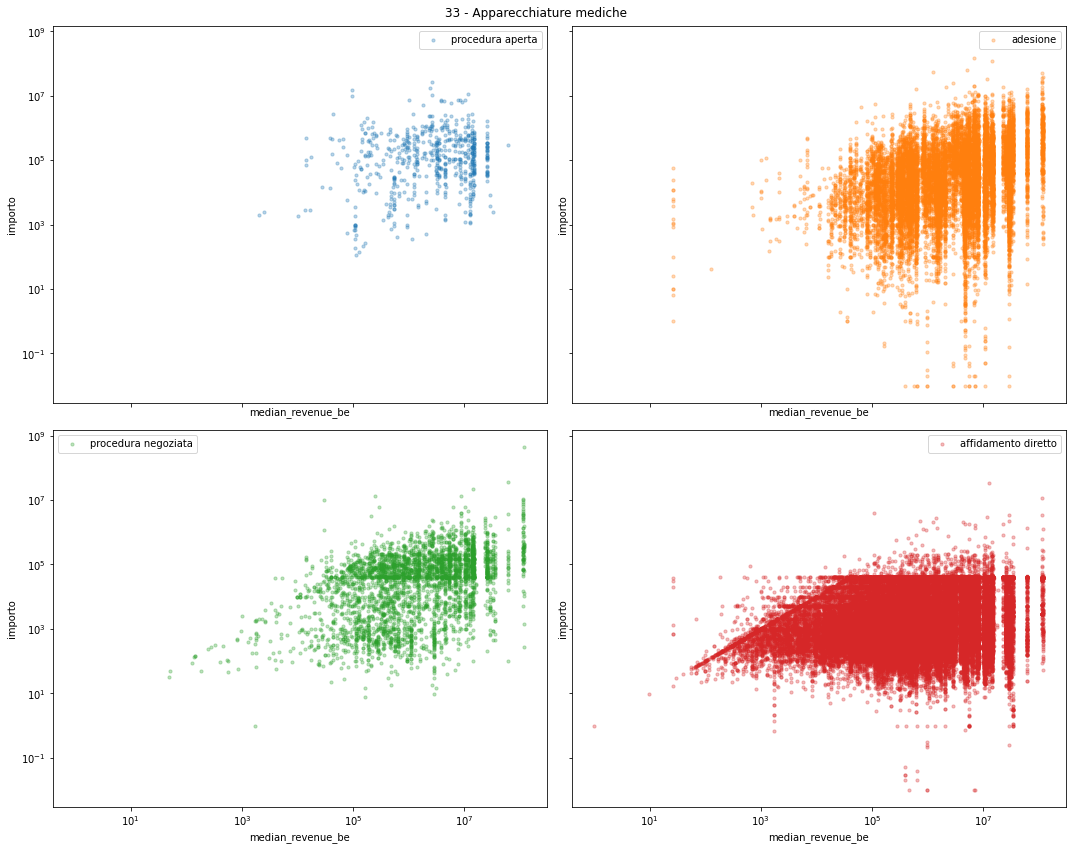

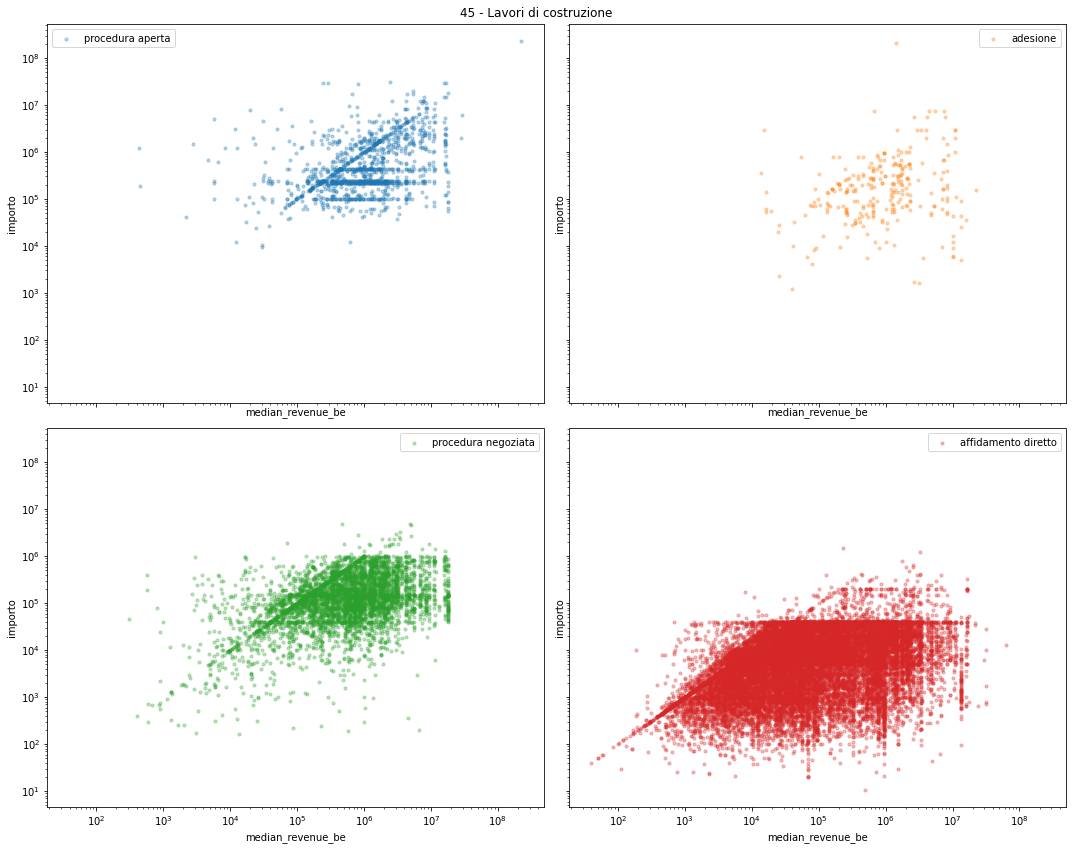

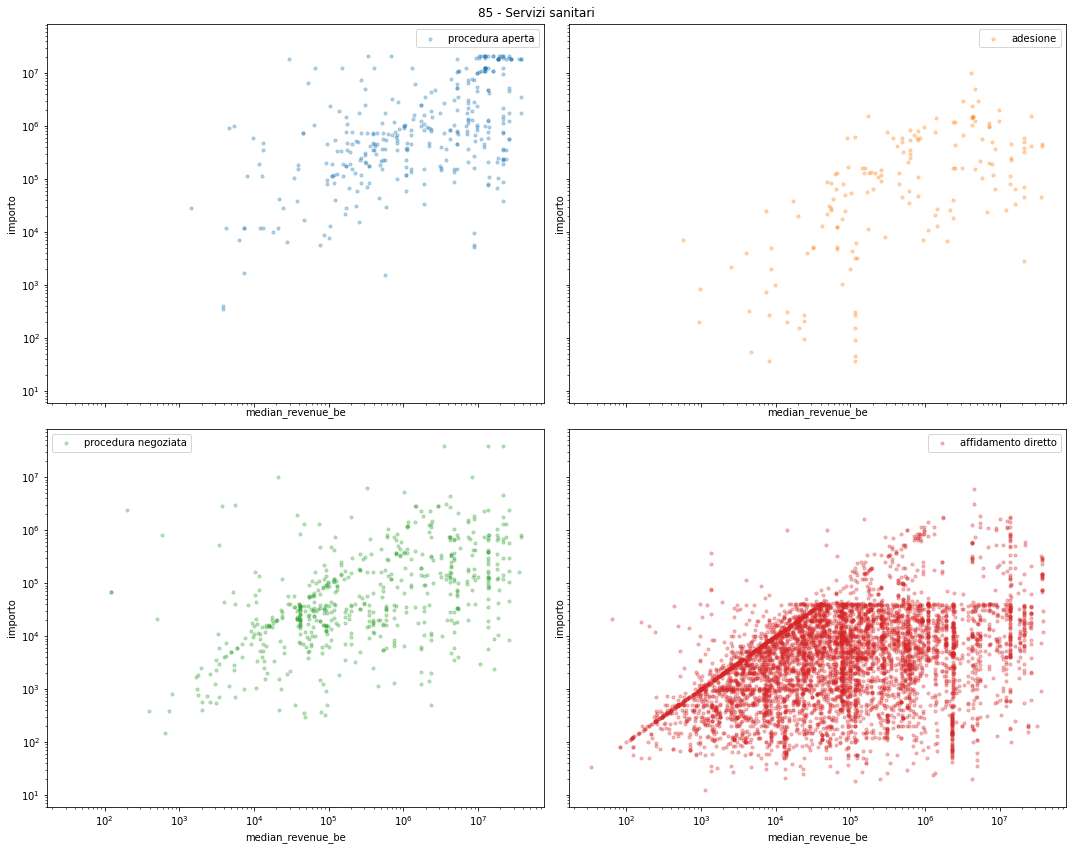

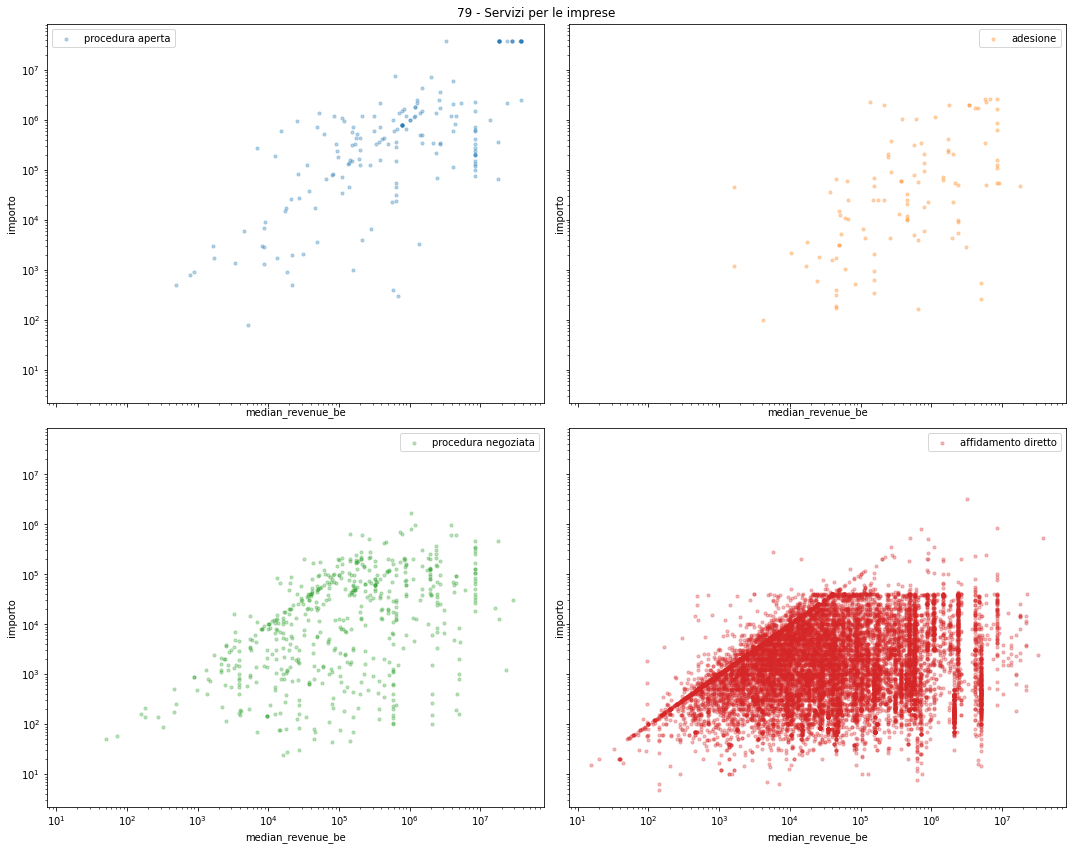

In [6]:
for cpv in abc_cpv:
    utils.scatter_quaternion("median_revenue_be", "importo", df, cpv)

the bigger the contract amount, the bigger the PA median annual expenditure?

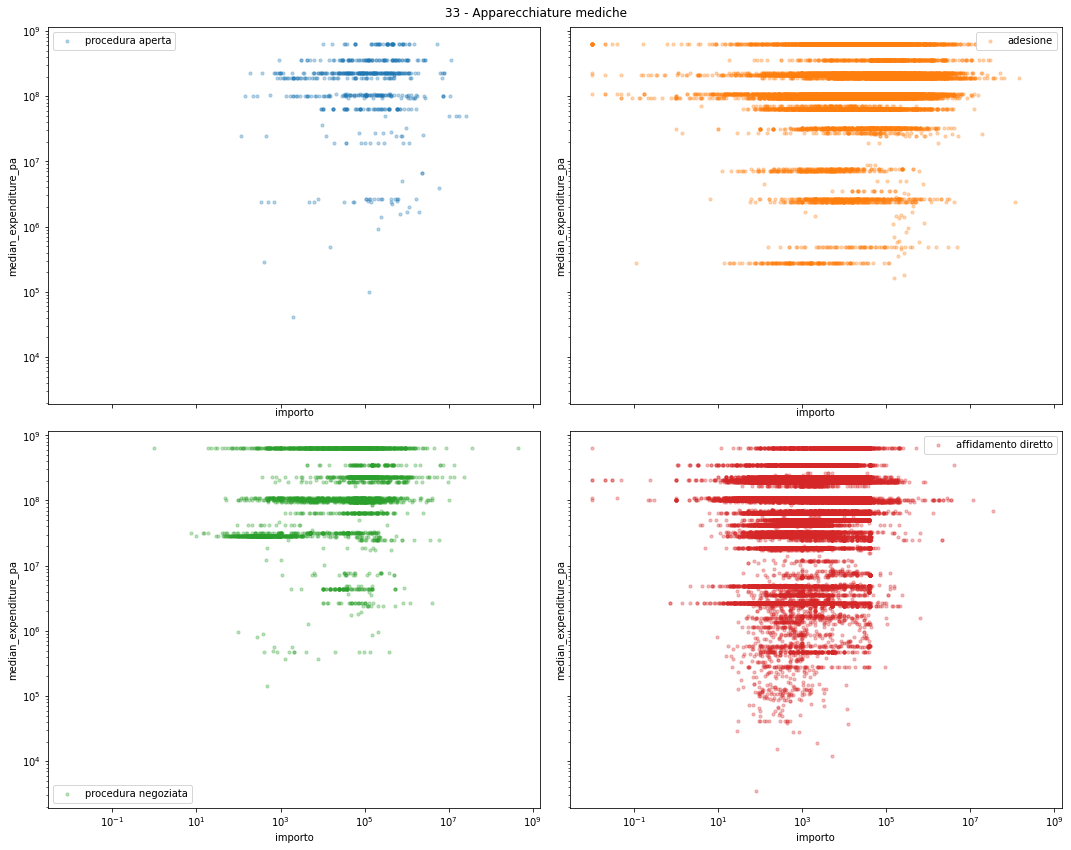

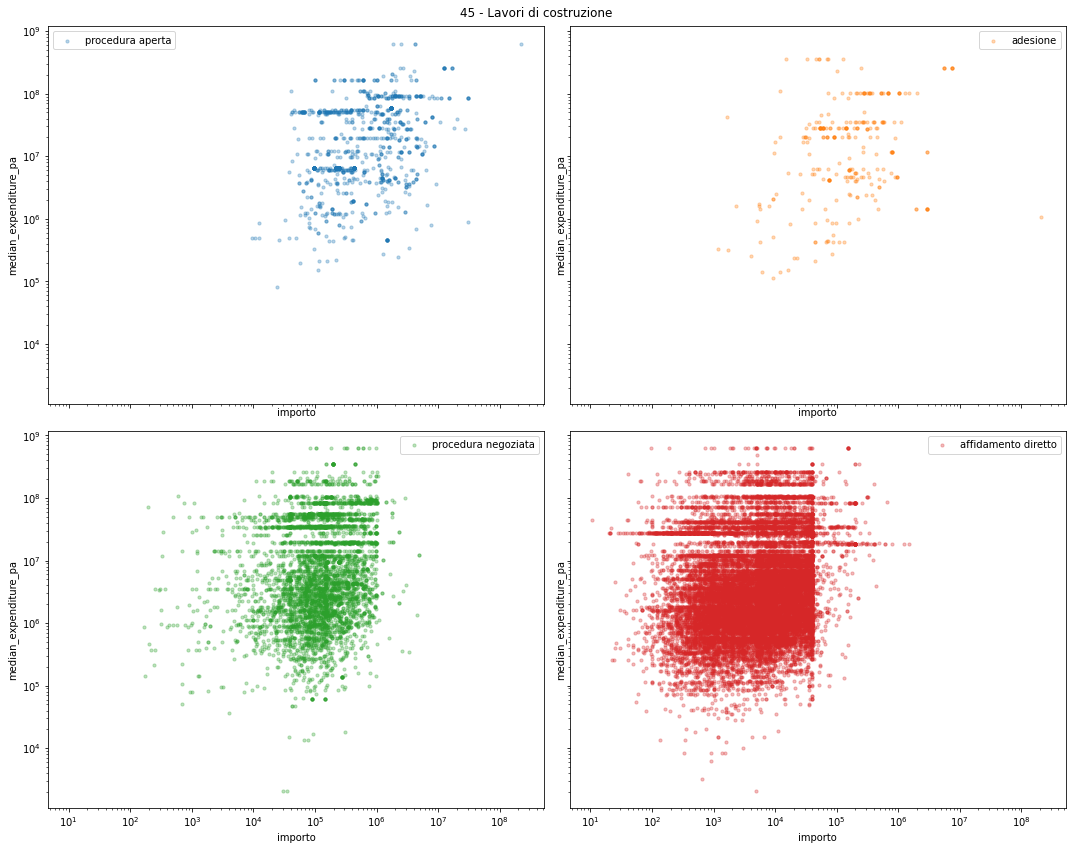

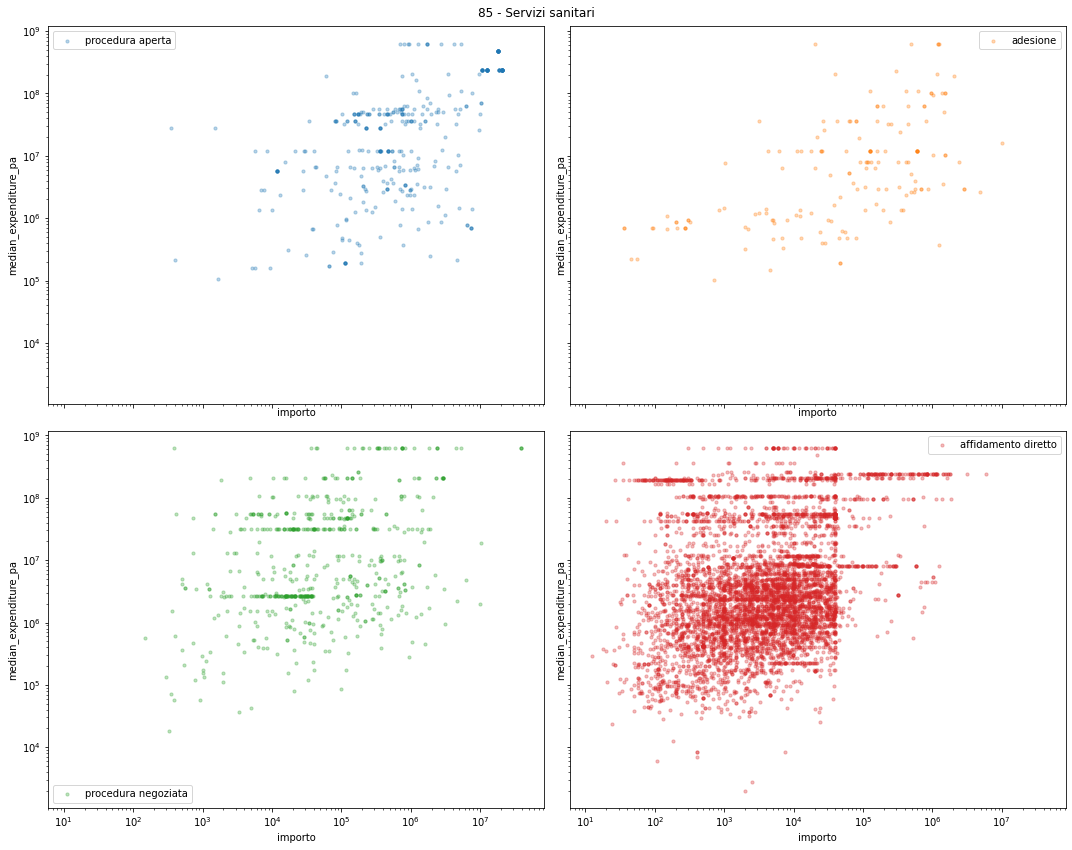

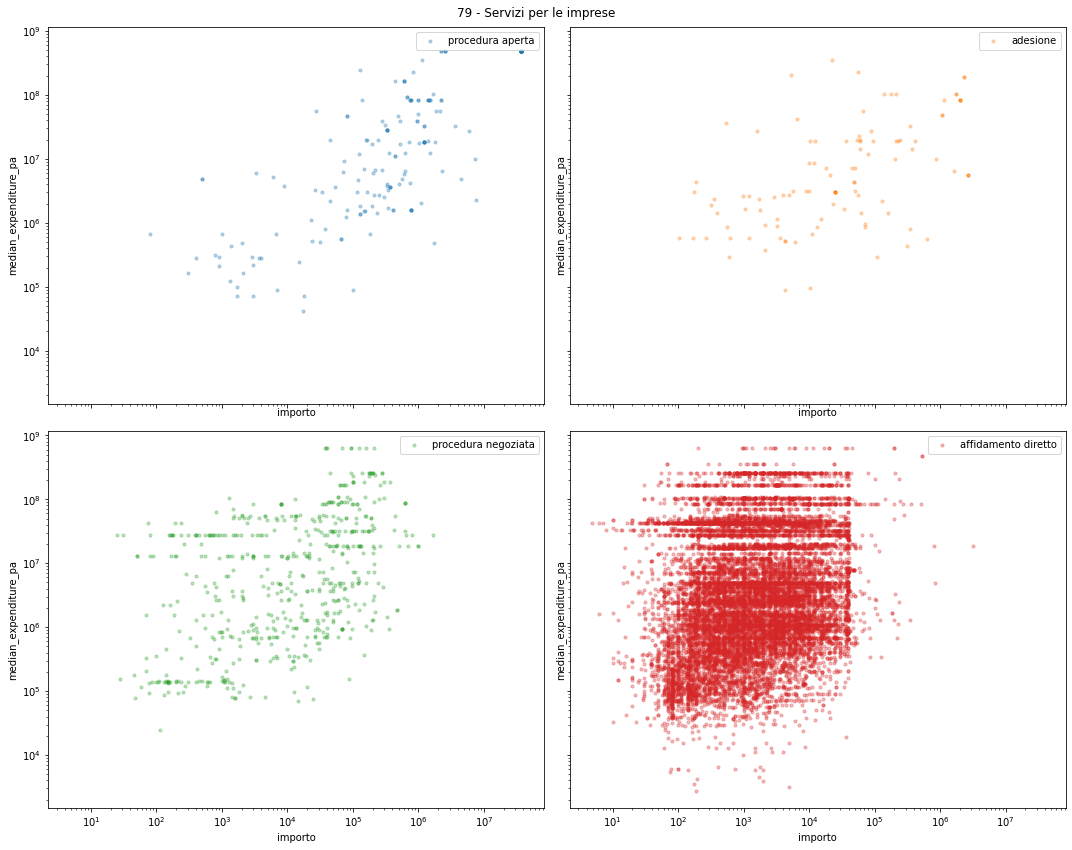

In [7]:
for cpv in abc_cpv:
    utils.scatter_quaternion("importo", "median_expenditure_pa", df, cpv)

do big PAs buy from big business entities?

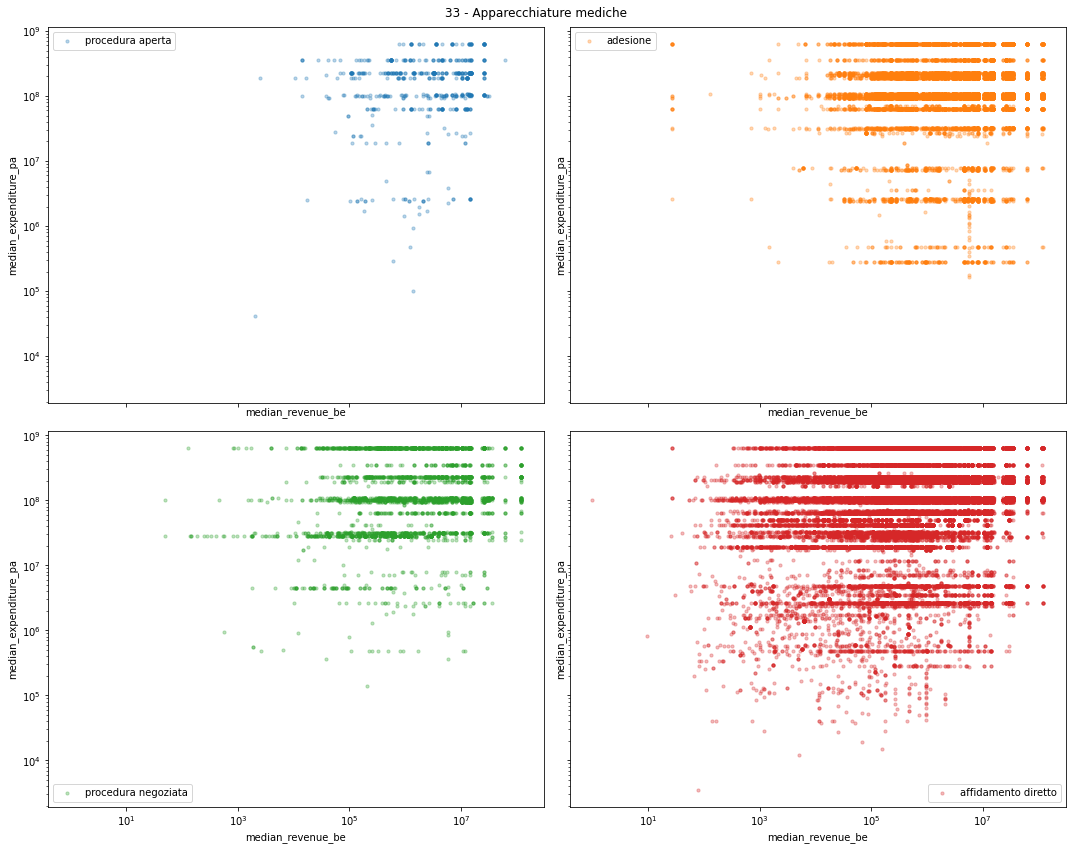

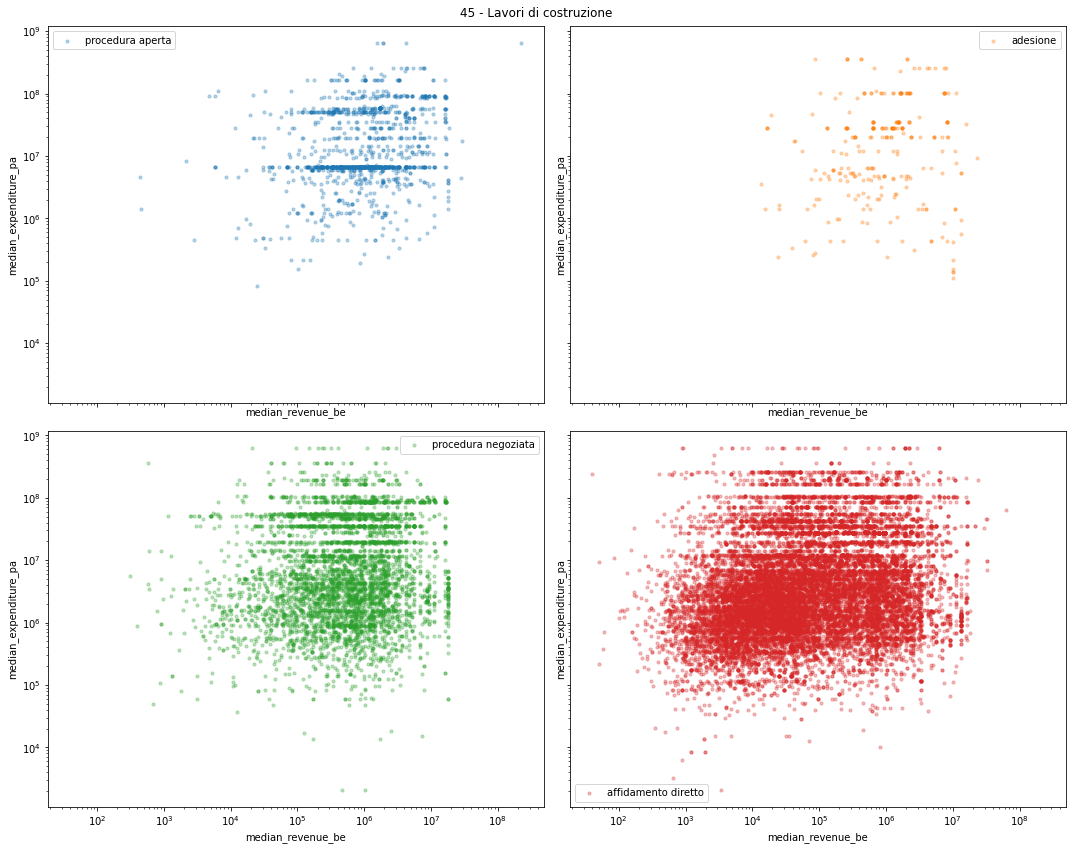

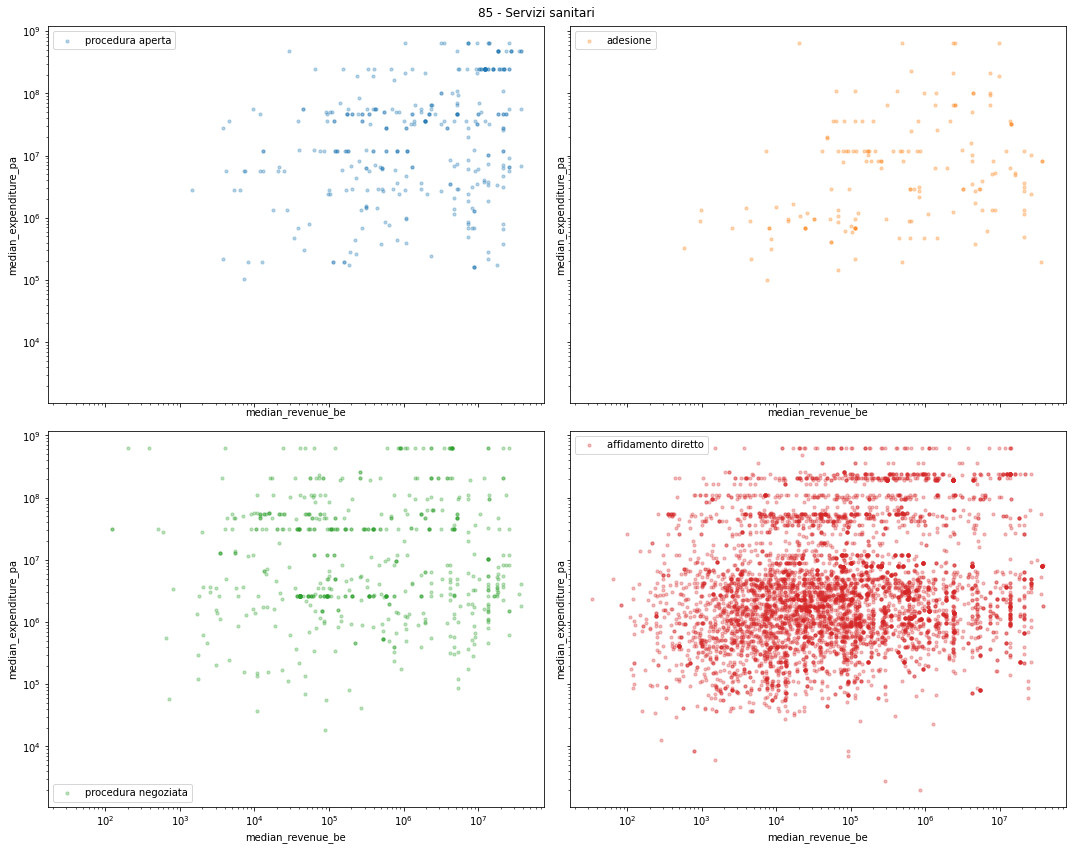

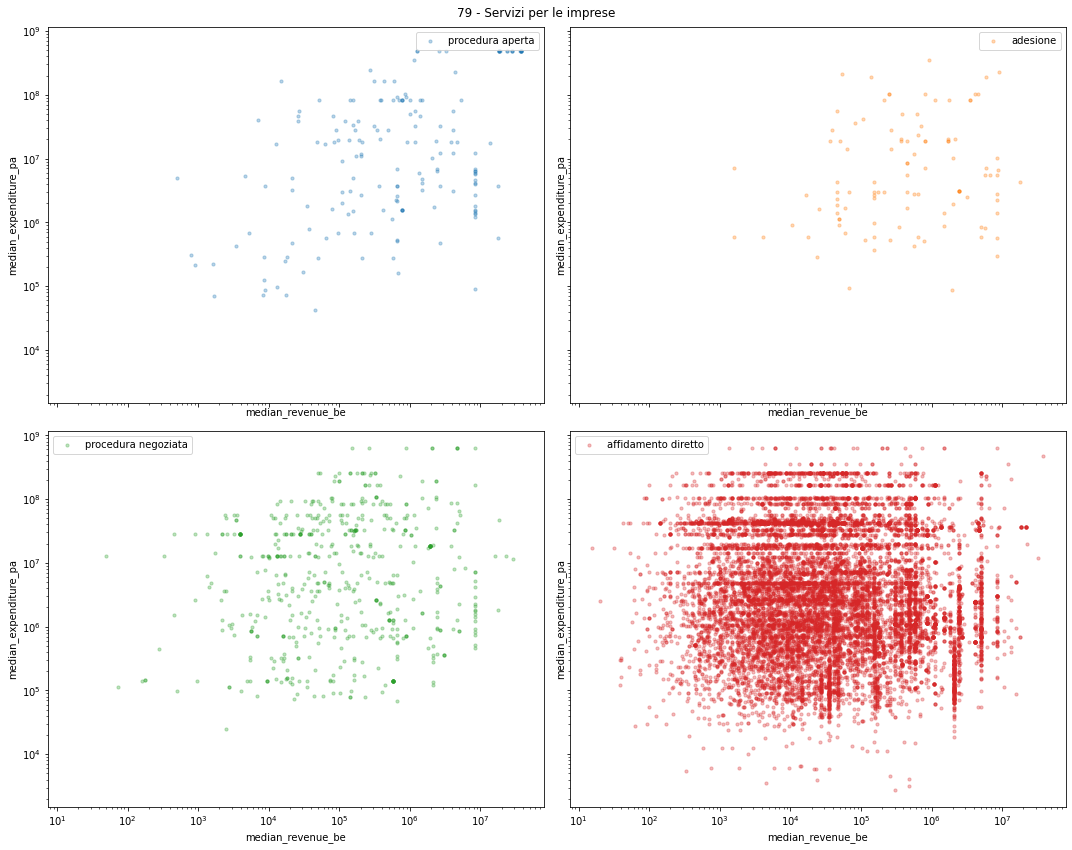

In [8]:
for cpv in abc_cpv:
    utils.scatter_quaternion("median_revenue_be", "median_expenditure_pa", df, cpv)

# time series

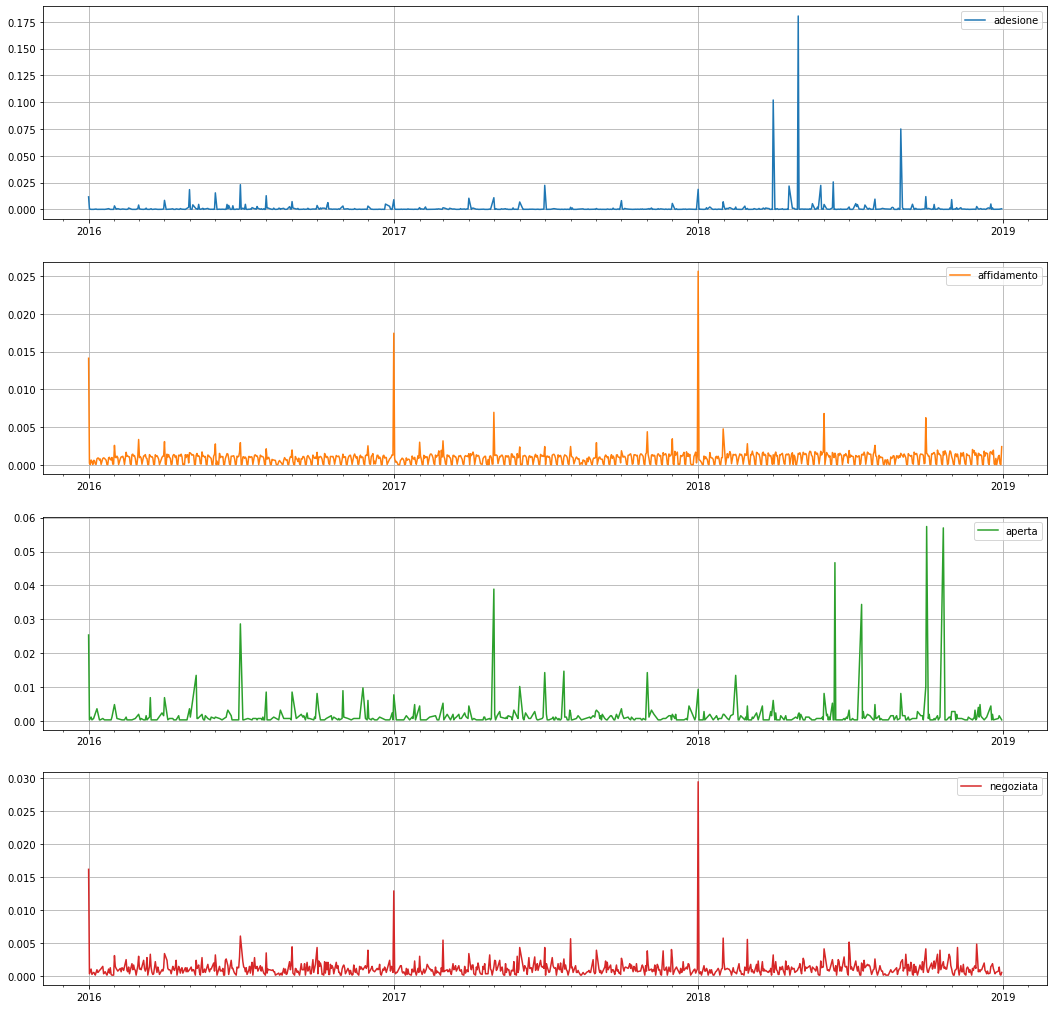

In [37]:
import matplotlib.colors as mcolors
from matplotlib.dates import MonthLocator, YearLocator, ConciseDateFormatter
n = len(abc_procedures)
fig, ax = plt.subplots(n, figsize=(6*3, 4.5*n))
for i, (name, group) in enumerate(df.groupby("tipo_procedura")):
    aggr = group.groupby("data_inizio").size()
    ax[i].plot(aggr / aggr.sum() , label=name, c=list(mcolors.TABLEAU_COLORS)[i])
    yloc = YearLocator()
    mloc = MonthLocator()
    ax[i].xaxis.set_major_locator(yloc)
    ax[i].xaxis.set_minor_locator(mloc)
    ax[i].grid()
    ax[i].legend()
plt.show()

il picco del numero di contratti nell'intorno dei primi giorni di Maggio del 2018 è dovuto a una gara regionale per l'acquisto di farmaci e vaccini per un'intero biennio.

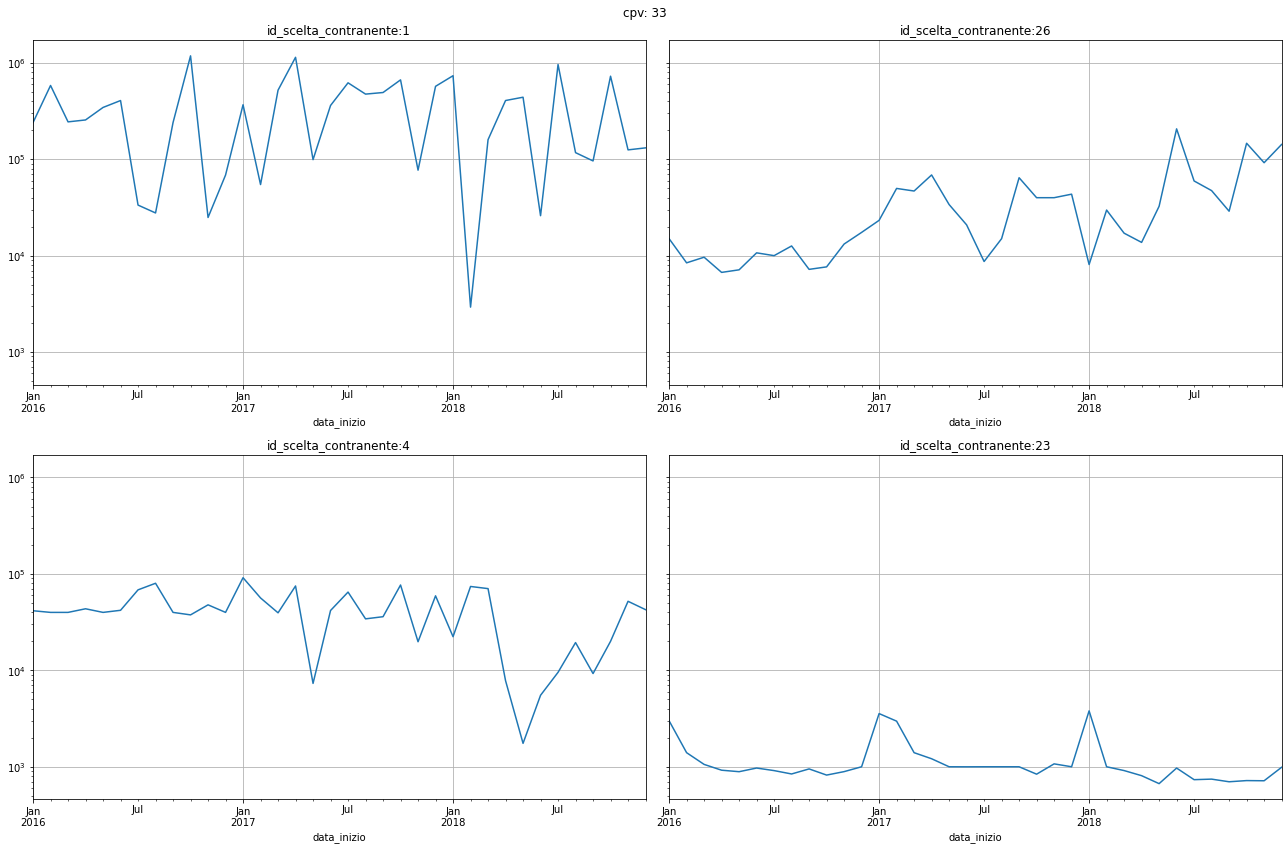

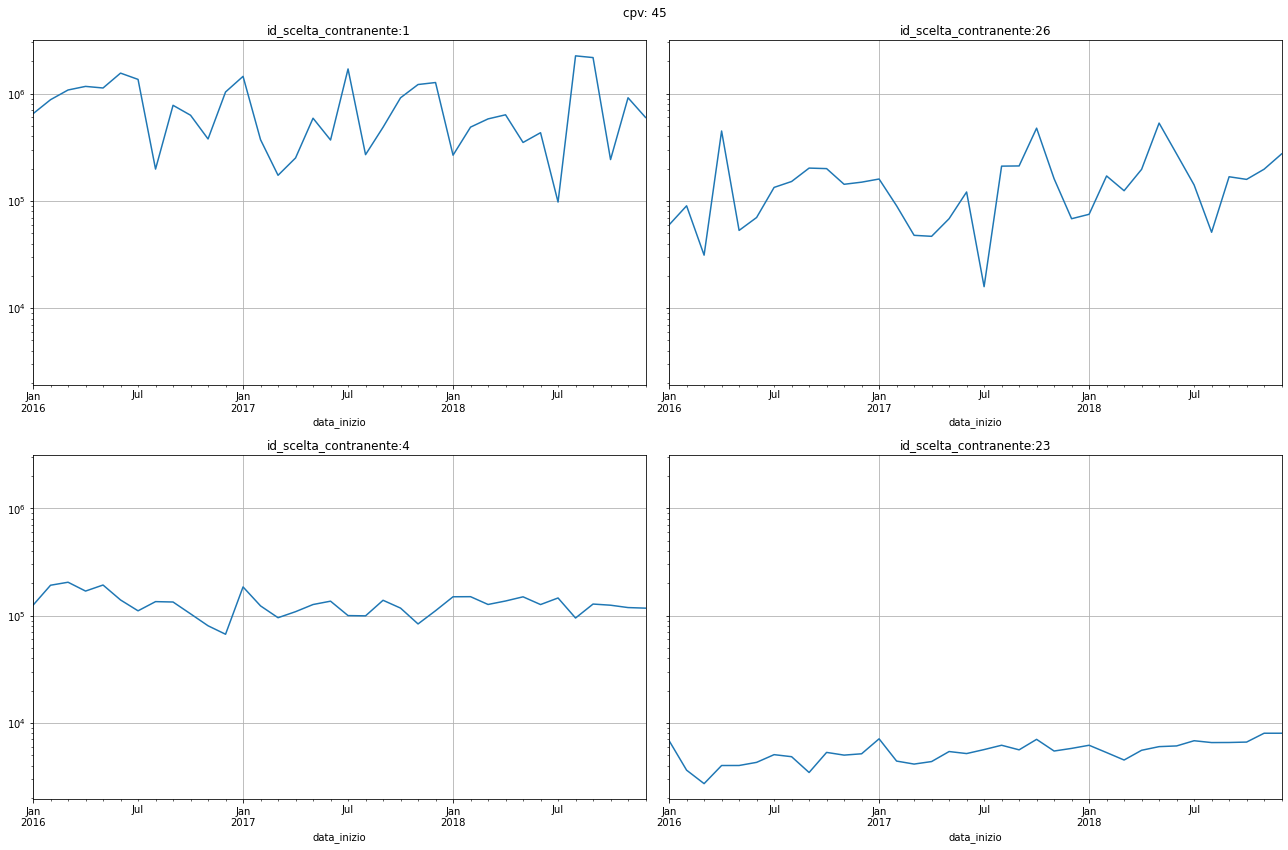

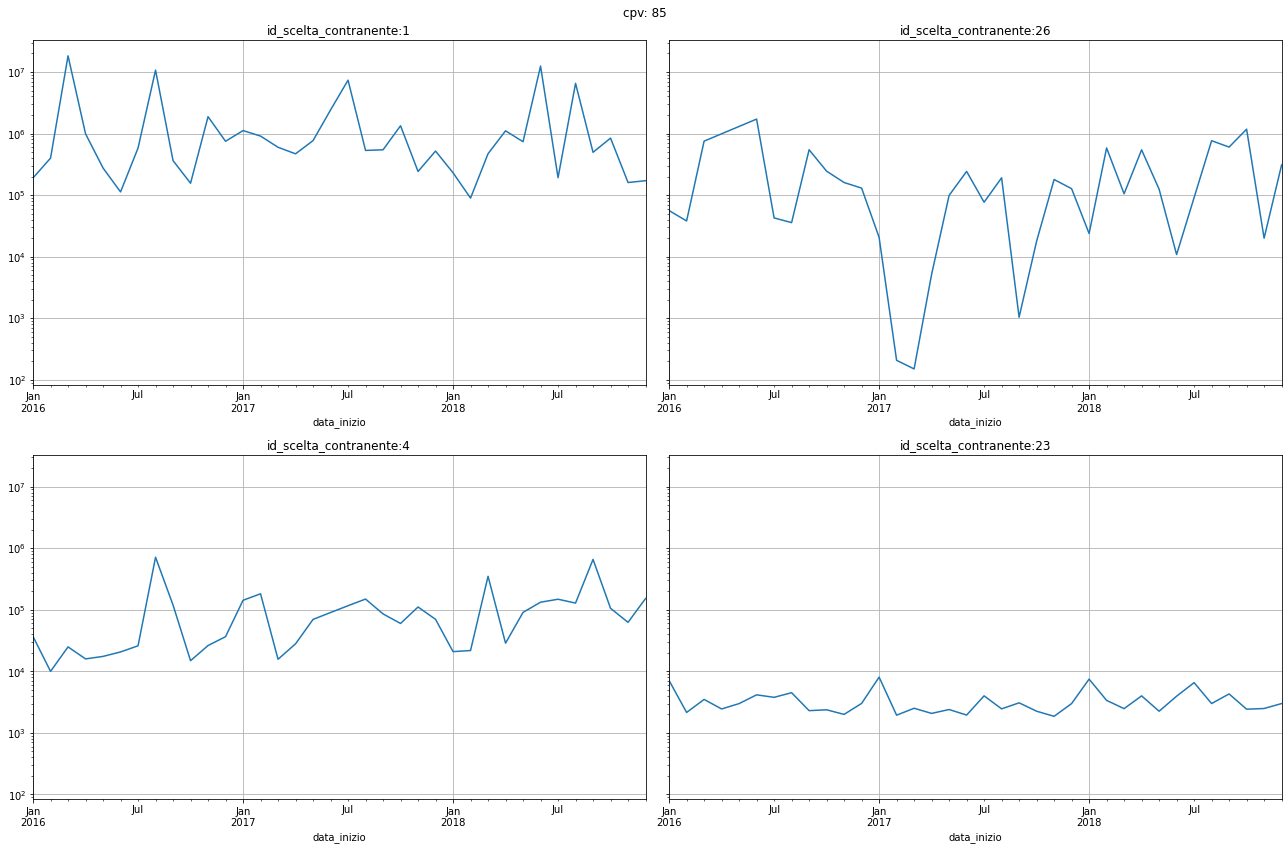

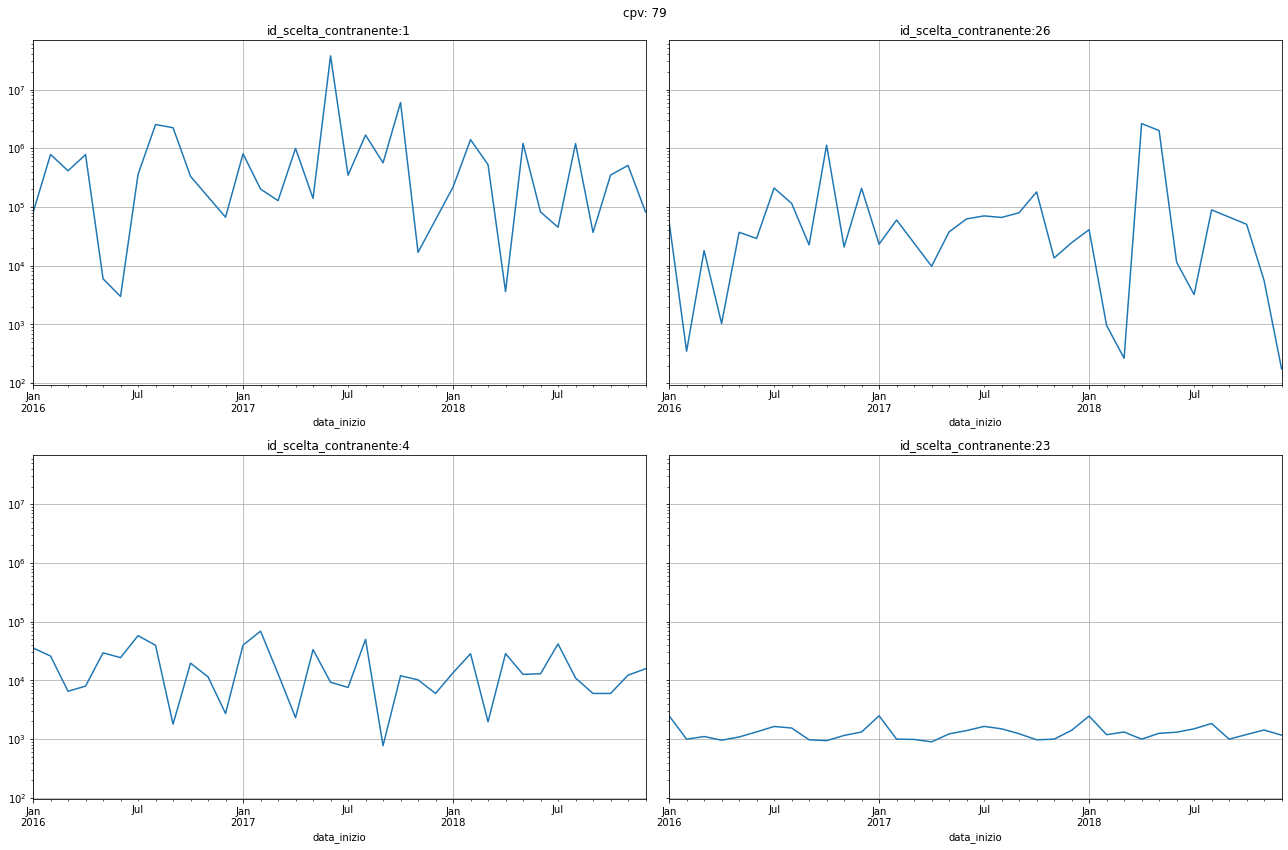

In [25]:
for cpv in abc_cpv:
    fig, ax = plt.subplots(2, 2, figsize=(6*3, 4*3), sharey=True)
    for i, procedure in enumerate(abc_scelta_contraente):
        table = df[(df.cpv == cpv) & (df.id_scelta_contraente == procedure)]
        table.groupby(table.data_inizio.dt.to_period("M")).importo.median().plot(ax=ax[i//2, i%2])
        ax[i//2, i%2].set_yscale("log")
        ax[i//2, i%2].set_title(f"id_scelta_contranente:{procedure}")
        ax[i//2, i%2].grid()
    fig.suptitle(f"cpv: {cpv}")
    plt.tight_layout()

eccetto per l'affidamento diretto, il resto delle procedure non presenta ciclicità rispetto agli importi

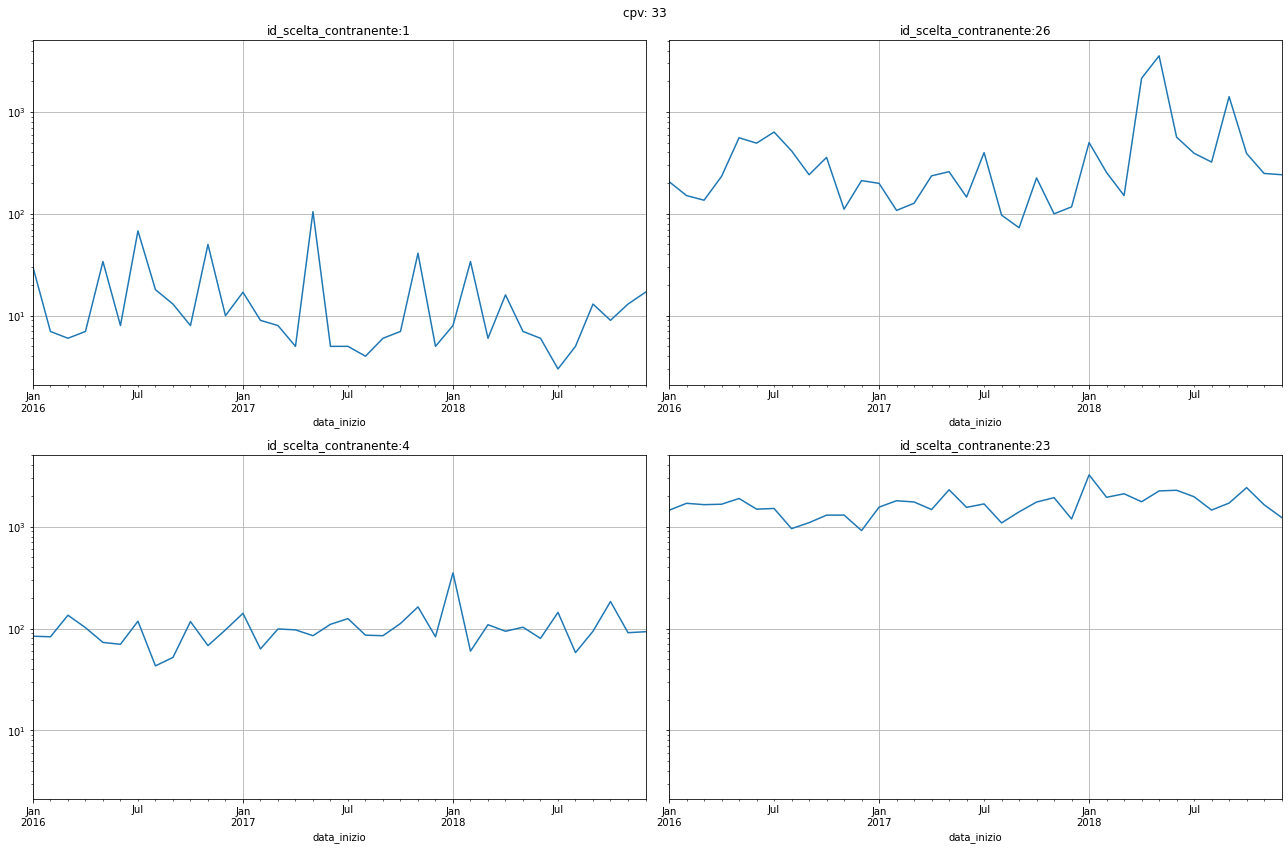

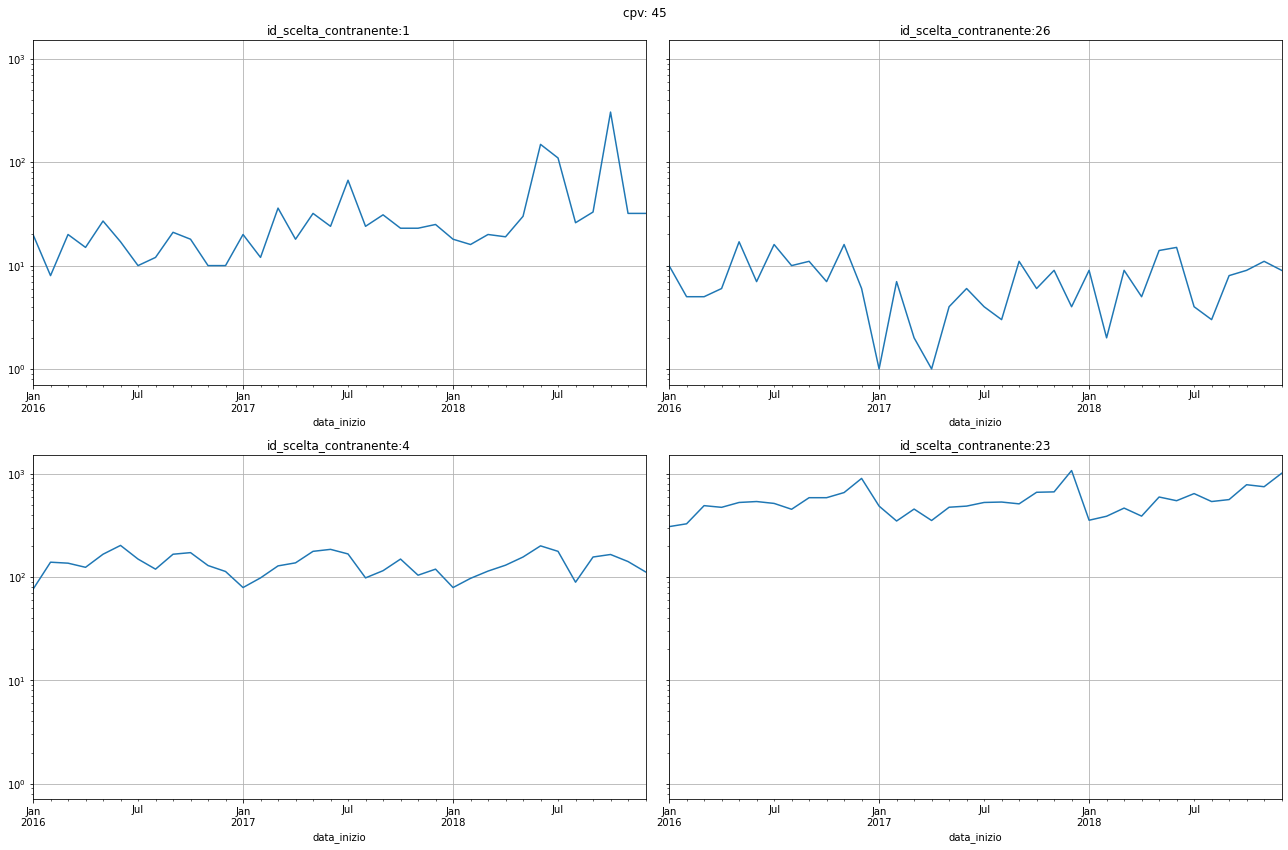

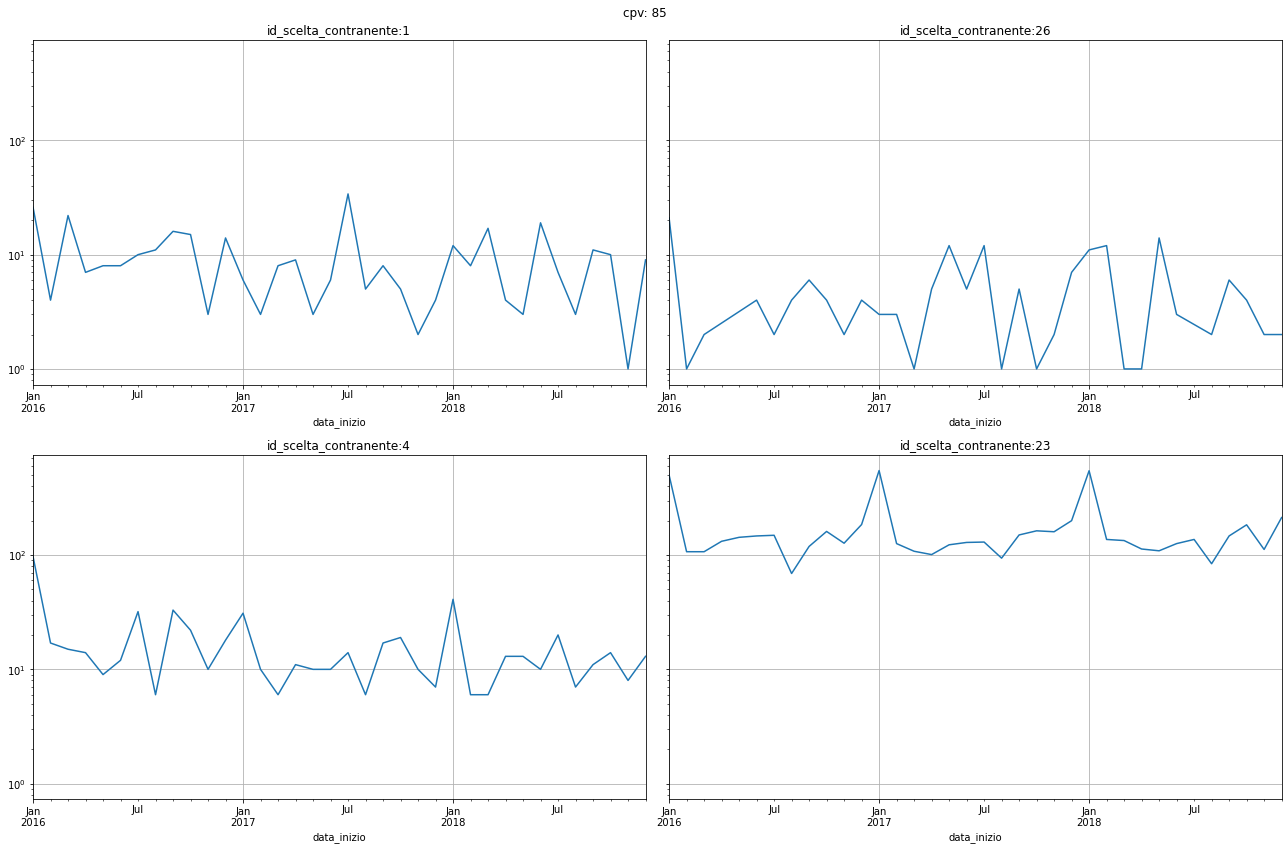

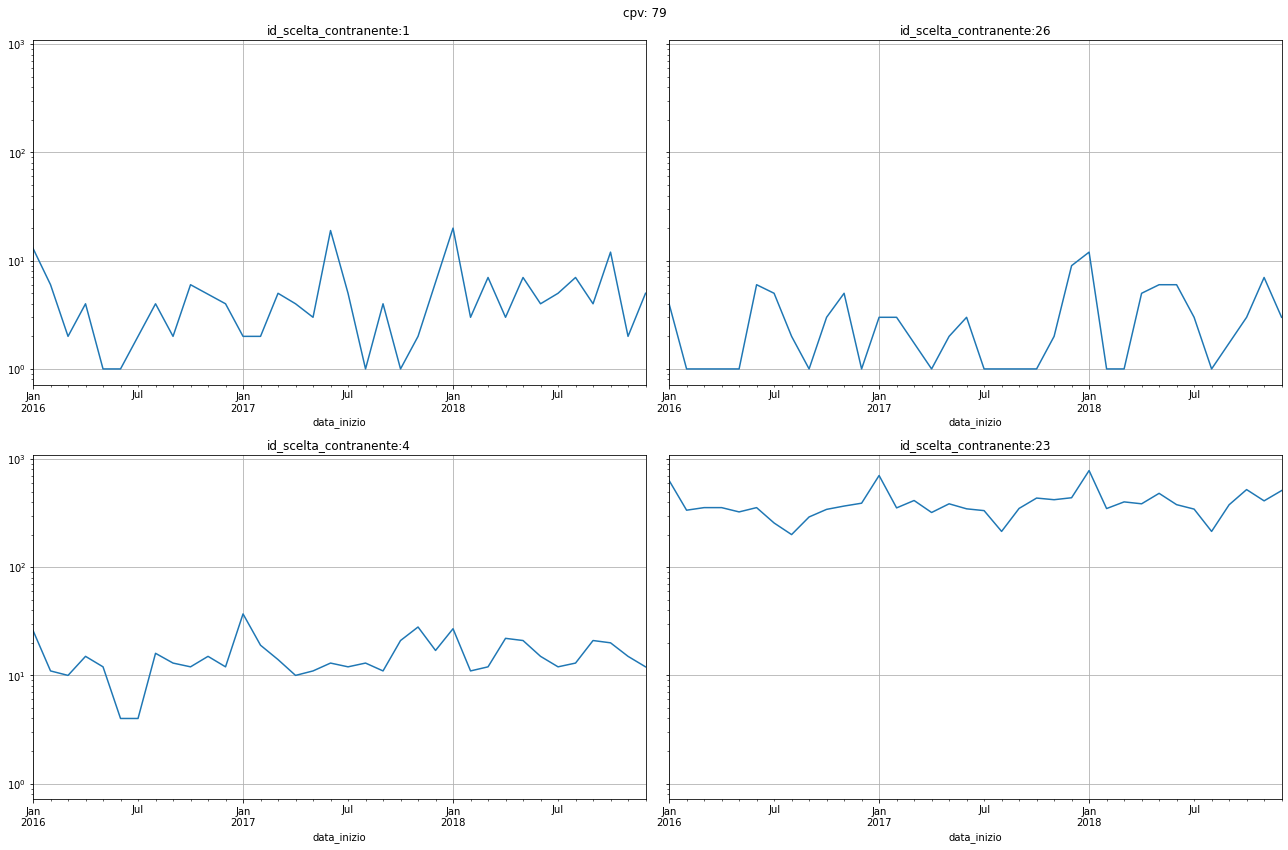

In [11]:
for cpv in abc_cpv:
    fig, ax = plt.subplots(2, 2, figsize=(6*3, 4*3), sharey=True)
    for i, procedure in enumerate(abc_scelta_contraente):
        table = df[(df.cpv == cpv) & (df.id_scelta_contraente == procedure)]
        table.groupby(table.data_inizio.dt.to_period("M")).importo.size().plot(ax=ax[i//2, i%2])
        ax[i//2, i%2].set_yscale("log")
        ax[i//2, i%2].set_title(f"id_scelta_contranente:{procedure}")
        ax[i//2, i%2].grid()
    fig.suptitle(f"cpv: {cpv}")
    plt.tight_layout()

anche qi direi che solo gli affidamenti diretti sono ciclici, mentre gli altri no.

# outlier classification and filtering
* near-illegal outliers. The contracts are not compliant to the at-that-time public procurement law. This is a first approximation as waivers and exceptions are possibile. 
* unsound/unreasable outliers. The contract values are very unrealistic given the other contract dimensions, such as the dimension of the firm or the duration
* statistical outliers. The contracts outlined by the evaluation of a statistical model applied to the dataset filtered of the previous outlier categories

## near-illegal outliers
according to https://www.bosettiegatti.eu/public/2019_memo_pubblicita.pdf

In [12]:
# append a new col to keep track of the changes
df["uncompliant"] = False

the only award procedures present in the dataset:
* 1 : "procedura aperta",
* 4 : "procedura ristretta",
* 23 : "affidamento diretto"

### works
* affidamento diretto: contract value < 150k
* procedura negoziata: 150k <= contract value < 1M
* procedura aperta: 1M <= contract value < 5.35M
* procedura aperta o ristretta: 5.35M >= contract value

In [13]:
# cpv does not match the lsf classification
sum(df.id_lsf == 1) - sum((df.id_lsf == 1) & (df.cpv == 45))

618

Let's forget about them. We will eventually keep them in consideration

In [38]:
# no dovrebbero esserci affidamenti diretti sopra i 150k
df.loc[(df.id_lsf == 1) & (df.id_scelta_contraente == 23) & (df.importo > 150e3), "uncompliant"] = True
# non dovrebbero esserci procedure aperte inferiori al 1M di euro
df.loc[(df.id_lsf == 1) & (df.id_scelta_contraente == 1) & (df.importo < 1e6), "uncompliant"] = True
# non dovrebbero esserci procedure ristrette inferiori ai 5.35M
df.loc[(df.id_lsf == 1) & (df.id_scelta_contraente == 4) & (df.importo < 5.35e6), "uncompliant"] = True

### goods and services
* affidamento diretto: contract value < 40k
* procedura negoziata: 140k <= contract value < 214k
* procedura aperta o ristretta: 214k >= contract value

In [40]:
# non dovrebbero esserci affidamenti diretti sopra i 40k
df.loc[(df.id_lsf != 1) & (df.id_scelta_contraente == 23) & (df.importo > 40e3), "uncompliant"] = True
# non dovrebbero esserci procedure aperte o ristrette sotto i 214k
df.loc[(df.id_lsf != 1) & (df.id_scelta_contraente == 1) & (df.importo < 214e3), "uncompliant"] = True
df.loc[(df.id_lsf != 1) & (df.id_scelta_contraente == 4) & (df.importo > 214e3), "uncompliant"] = True

In [41]:
sum(df.uncompliant)

7896

## unsound/unreasonable outliers

1. contracts having a value higher than the median annual revenue of the business entity winning the bid and of the median expenditure of the public commissioning body (stazione appaltante). Both the business entity and the commissioning body must have a median annual number of contracts higher or equal than five.

In [42]:
df["unsound"] = False

In [43]:
min_year_contr_th = 5
rev_exp_mask = (df.importo > df.median_revenue_be) & (df.importo > df.median_expenditure_pa)
min_year_contr_mask = (df.med_yearly_n_contr_be > min_year_contr_th) & (df.med_yearly_n_contr_pa > min_year_contr_th)
df.loc[rev_exp_mask & min_year_contr_mask, "unsound"] = True

In [44]:
relevant_attributes = ["importo", "cpv", "durata", 
                       "median_revenue_be", "med_yearly_n_contr_be", 
                       "median_expenditure_pa", "med_yearly_n_contr_pa"]
df[df.unsound][relevant_attributes]

importo  cpv    durata  median_revenue_be  med_yearly_n_contr_be  \
147144    3.40M   45  489 days              2.69M                   7.00   
301546  604.50k   33 1052 days            225.69k                   8.00   
312636  117.78M   33 1003 days             14.21M                 361.00   
315028    6.28M   45  734 days              3.00M                   6.00   
354667    2.89M   45  476 days            408.13k                  17.00   
356630  274.05k   45  180 days            148.79k                  28.00   
356631  274.05k   45  180 days            265.59k                  13.00   
391428  608.00k   45 1460 days            142.25k                   6.00   
407688    4.93M   85 1095 days              4.71M                   8.00   
429764    6.53M   85 1095 days             53.10k                  11.00   
452416    4.41M   45  642 days              3.09M                  21.00   
675287    5.80M   33 1256 days              5.74M                  36.00   
681356    1.58M   45  781 days            843.53k                  13.00   
695820    2.00M   33 1521 days            180.13k                  15.00   
704876  205.54M   45  147 days              1.45M                  11.00   
705278    1.45M   45  550 days            398.32k                  20.00   
705279    1.45M   45  550 days              2.79k                   6.00   
705280    1.45M   45  550 days            236.71k                   7.00   
716184   10.11M   85 2191 days              8.22M                   7.00   

        median_expenditure_pa  med_yearly_n_contr_pa  
147144                  2.52M                 142.00  
301546                579.61k                  29.00  
312636                  2.39M                  16.00  
315028                  6.12M                 248.00  
354667                  1.28M                 271.00  
356630                138.59k                  78.00  
356631                138.59k                  78.00  
391428                454.50k                  69.00  
407688                  2.67M                  12.00  
429764                793.01k                 100.00  
452416                684.57k                 109.00  
675287                  3.90M                 137.00  
681356                584.98k                  78.00  
695820                  1.70M                  65.50  
704876                  1.05M                  86.00  
705278                453.03k                  10.00  
705279                453.03k                  10.00  
705280                453.03k                  10.00  
716184                  1.99M                 198.00

2. affidamenti diretti having contract duration lasting longer than 10 years

In [45]:
n_years = 10
years_mask = (df.id_scelta_contraente == 23) & (df.durata.dt.days > n_years * 365)
sum(years_mask)
df.loc[years_mask, "unsound"] = True
df[years_mask][relevant_attributes]

importo  cpv    durata  median_revenue_be  med_yearly_n_contr_be  \
45264    49.00k   45 4383 days             49.61k                   2.00   
371881   38.00k   79 3847 days             38.00k                   1.00   
445990    6.70k   79 4016 days              5.34k                   1.50   
446018    5.38k   79 4016 days              5.38k                   1.00   
446019    5.38k   79 4016 days             67.41k                  11.00   
446146   12.27k   79 4016 days             27.30k                   7.00   
446560    3.54k   79 4016 days              3.54k                   1.00   
446590    1.74k   79 3919 days              5.34k                   1.50   
446591   409.84   79 3784 days             28.84k                   3.00   
446593    4.78k   79 4002 days             93.37k                  10.00   
446594    2.14k   79 3653 days              1.65k                   1.00   
446596    1.14k   79 3950 days              1.65k                   1.00   
591345   15.00k   79 3652 days             15.00k                   1.00   
699146   49.83k   79 3651 days             10.30k                   4.00   
711869    7.50k   85 4659 days              2.54k                   3.00   

        median_expenditure_pa  med_yearly_n_contr_pa  
45264                   6.33M                 104.00  
371881                  5.75M                 366.00  
445990                  2.39M                  99.00  
446018                  2.39M                  99.00  
446019                  2.39M                  99.00  
446146                  2.39M                  99.00  
446560                  2.39M                  99.00  
446590                  2.39M                  99.00  
446591                  2.39M                  99.00  
446593                  2.39M                  99.00  
446594                  2.39M                  99.00  
446596                  2.39M                  99.00  
591345                  1.33M                 150.00  
699146                  3.09M                   4.00  
711869                  5.98M                 254.00

3. contracts having a value 25 times higher than the median revenue of business entity and more than 5 contracts (median)

In [46]:
coef = 25
coef_mask = (df.importo > coef * df.median_revenue_be) & (df.med_yearly_n_contr_be > 5)
df.loc[coef_mask, "unsound"] = True
df.loc[coef_mask, relevant_attributes]

importo  cpv    durata  median_revenue_be  med_yearly_n_contr_be  \
31713     4.46M   33 2009 days             62.47k                   6.00   
60826     1.40M   79 1786 days             52.24k                  11.00   
89682    27.24M   45 1094 days            805.64k                  10.00   
99458   470.35k   85 1095 days             13.04k                  30.00   
104224   18.27M   85  291 days             29.08k                   6.00   
170757   52.92M   33  771 days              1.27M                  29.00   
208558   15.00M   33  821 days             94.87k                   6.00   
317284    5.75M   33  688 days            113.39k                  11.00   
319872   30.00M   45  679 days            245.27k                   7.00   
333305    1.21M   33  365 days             30.23k                  11.00   
349964    1.23M   45  268 days              8.37k                  18.00   
376930  406.68k   45  365 days              6.66k                  36.00   
429764    6.53M   85 1095 days             53.10k                  11.00   
445754  320.00k   45  242 days              4.69k                   8.00   
479905    1.51M   33  824 days             51.94k                   6.00   
490566   15.69M   33  688 days            624.78k                  82.00   
491372    3.99M   33  729 days            107.30k                  14.00   
518961  960.00k   79 1074 days             25.61k                   7.00   
570522  285.25k   79  537 days              5.80k                  34.00   
604136   10.00M   33  821 days             94.87k                   6.00   
688688  356.78k   85 1095 days             13.04k                  30.00   
704876  205.54M   45  147 days              1.45M                  11.00   
705279    1.45M   45  550 days              2.79k                   6.00   
751297    4.60M   45  776 days            164.04k                  10.00   
755107   20.61M   85  183 days            679.18k                  10.00   

        median_expenditure_pa  med_yearly_n_contr_pa  
31713                 101.71M                  2.46k  
60826                  84.30M                 657.00  
89682                  27.24M                   5.00  
99458                  11.86M                 303.00  
104224                481.50M                  37.00  
170757                189.71M                  2.05k  
208558                 49.45M                 668.00  
317284                189.71M                  2.05k  
319872                 86.51M                 344.00  
333305                228.08M                  2.94k  
349964                  4.55M                 353.00  
376930                  1.82M                  26.00  
429764                793.01k                 100.00  
445754                  3.08M                  99.00  
479905                228.08M                  2.94k  
490566                189.71M                  2.05k  
491372                354.66M                  1.47k  
518961                 38.85M                 892.00  
570522                 57.08M                 191.00  
604136                 49.45M                 668.00  
688688                 11.86M                 303.00  
704876                  1.05M                  86.00  
705279                453.03k                  10.00  
751297                 13.80M                   3.00  
755107                241.96M                 260.00

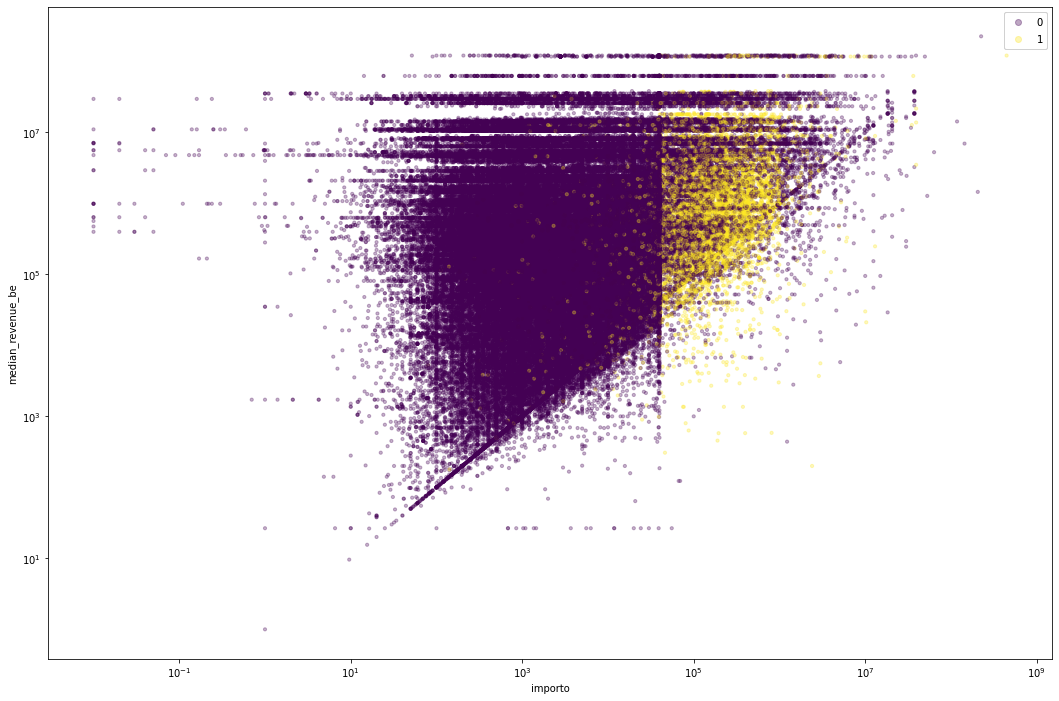

In [47]:
utils.compare_filtering(df, "importo", "median_revenue_be", "uncompliant")
# 1: uncompliant contracts
# 0: compliant contracts

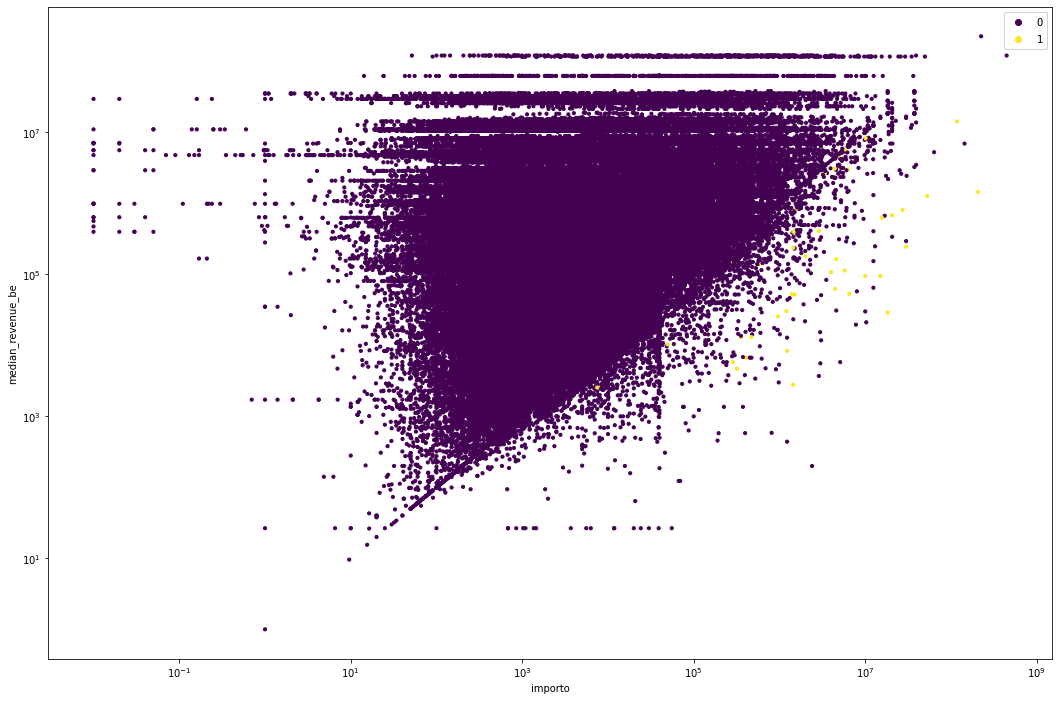

In [49]:
utils.compare_filtering(df, "importo", "median_revenue_be", "unsound", alpha=1)

# da chiedere a Claudio:
1. sono le gare o i lotti a dover rispettare i vincoli di cui sopra?
2. quanto scorretto è che esistano gare che non rispettino i limiti di cui sopra? sono relativamente comuni le infrazioni al codice degli appalti

In [52]:
# percentuale di contratti "near-illegal"
sum(df.uncompliant) / df.shape[0] * 100

6.118132017139448